# njcls job corps – causalpfn vs jc impacts

_baseline from national job corps study impact report (`01-jcimpacts.pdf`). pulling year-4 employment/earnings targets straight from the pdf for benchmarking against causalpfn._

In [1]:
import os
import random
import re
from pathlib import Path

import numpy as np
import pandas as pd
import pdfplumber
import matplotlib.pyplot as plt
import pyreadstat
import torch
from causalpfn import ATEEstimator, CATEEstimator
import causalpfn.causal_estimator as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor

# keep mac runs stable
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
os.environ.setdefault("VECLIB_MAXIMUM_THREADS", "1")
os.environ.setdefault("NUMEXPR_NUM_THREADS", "1")
torch.set_num_threads(1)
torch.set_num_interop_threads(1)

# paths
NJCLS_DIR = Path("/Users/richardguo/csc494-spatialpfn/economics/njcls")
DATA_DIR = NJCLS_DIR / "113269-V1"
PDF_PATH = NJCLS_DIR / "01-jcimpacts.pdf"
RESULTS_DIR = NJCLS_DIR / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
OUT_CSV = RESULTS_DIR / "njcls_causalpfn_notebook.csv"

# treatment + covariates
TREAT_COL = "TREATMNT"
TREATED_VALUES = {1.0}
CONTROL_VALUES = {0.0}
COVARIATES = [
    "FEMALE",
    "AGE_CAT",
    "RACE_ETH",
    "HASCHLD",
    "AFTER_ZT",
    "ARRST_GR",
    "EDUC_GR",
    "AGEGROUP",
    "INPERS",
    "IN57",
    "TYPEAREA",
    "HS_GED",
]
OUTCOME_SPECS = {
    "earnings_per_week_year4": "EARNY4",
    "weeks_employed_pct_year4": "PWORKY4",
    "hours_worked_per_week_year4": "HRSWY4",
}
DEVICE = "cpu"
TEST_FRAC = 0.2
N_SPLITS = int(os.getenv("NJCLS_N_SPLITS", "8"))
BASE_SEED = 2025
OUTCOME_SEED_OFFSET = {
    "earnings_per_week_year4": 11,
    "weeks_employed_pct_year4": 17,
    "hours_worked_per_week_year4": 23,
}

# patch causalpfn weak learner for small n splits

def _safe_train_weak_learner(self, X, t, y) -> GradientBoostingRegressor:
    self.t_transformer = OneHotEncoder(sparse_output=False, categories="auto", drop="first")
    T = self.t_transformer.fit_transform(t.reshape(-1, 1))
    self._d_t = (T.shape[1],)
    feat_arr = np.concatenate((X, 1 - np.sum(T, axis=1).reshape(-1, 1), T), axis=1)
    min_leaf = max(1, int(X.shape[0] / 100))
    self.stratifier = GradientBoostingRegressor(
        n_estimators=100,
        max_depth=6,
        min_samples_leaf=min_leaf,
        random_state=111,
    )
    self.stratifier.fit(feat_arr, y)


ce.CausalEstimator._train_weak_learner = _safe_train_weak_learner

/Users/richardguo/.pyenv/versions/3.11.8/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# pull year-4 targets directly from the impact report pdf
with pdfplumber.open(PDF_PATH) as pdf:
    raw_text = " ".join([page.extract_text() or "" for page in pdf.pages])
clean_text = " ".join(raw_text.split())

patterns = {
    "earnings_per_week_year4": re.compile(r"year 4[^.]*?\$([0-9]+\.?[0-9]*) per week[^$]*?\$([0-9]+\.?[0-9]*) per week", re.IGNORECASE),
    "weeks_employed_pct_year4": re.compile(r"year 4[^%]*?(\d+\.?\d*) percent for the program group[^%]*?(\d+\.?\d*) percent for the control group", re.IGNORECASE),
    "hours_worked_per_week_year4": re.compile(r"year 4[^)]*?(\d+\.?\d*) hours for the program group[^)]*?(\d+\.?\d*) hours for the control group", re.IGNORECASE),
}

bench_rows: list[dict] = []
for metric, pat in patterns.items():
    m = pat.search(clean_text)
    if not m:
        print(f"no match found for {metric}")
        continue
    pg, ctrl = map(float, m.groups()[:2])
    bench_rows.append(
        {
            "metric": metric,
            "program_group": pg,
            "control_group": ctrl,
            "reported_diff": pg - ctrl,
            "pattern": pat.pattern,
        }
    )

bench_df = pd.DataFrame(bench_rows)
bench_df

,metric,program_group,control_group,reported_diff,pattern
0,earnings_per_week_year4,211.0,195.0,16.0,year 4[^.]*?\$([0-9]+\.?[0-9]*) per week[^$]*?...
1,weeks_employed_pct_year4,69.0,66.0,3.0,year 4[^%]*?(\d+\.?\d*) percent for the progra...
2,hours_worked_per_week_year4,27.4,26.0,1.4,year 4[^)]*?(\d+\.?\d*) hours for the program ...


In [3]:
# load analytic files
impact_df, impact_meta = pyreadstat.read_sas7bdat(DATA_DIR / "impact.sas7bdat")
key_df, key_meta = pyreadstat.read_sas7bdat(DATA_DIR / "key_vars.sas7bdat")
keep_cols = ["MPRID", TREAT_COL] + COVARIATES
df = impact_df.merge(key_df[keep_cols], on="MPRID", how="left")
print(df.shape)
df.head()

(11313, 1119)


,MPRID,EVERJC,EVERJCH,EMBARGO,EVERJC30,INJCQ1,INJCQ2,INJCQ3,INJCQ4,INJCQ5,...,RACE_ETH,HASCHLD,AFTER_ZT,ARRST_GR,EDUC_GR,AGEGROUP,INPERS,IN57,TYPEAREA,HS_GED
0,00048033,1.0,1.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,...,3.0,1.0,0.0,1.0,1.0,3.0,1.0,0.0,2.0,0.0
1,00056067,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,0.0,1.0,3.0,3.0,1.0,1.0,1.0,1.0
2,00060037,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,2.0,2.0,1.0,0.0,2.0,1.0
3,00075019,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,00077017,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0


In [4]:
# helper utils
def set_all_seeds(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


def split_idx(n: int, test_frac: float, seed: int):
    rng = np.random.default_rng(seed)
    idx = np.arange(n)
    rng.shuffle(idx)
    n_test = max(1, int(round(test_frac * n)))
    te = idx[:n_test]
    tr = idx[n_test:]
    return tr, te


def standardize_train_apply(Xtr: np.ndarray, Xte: np.ndarray, eps: float = 1e-8):
    mu = Xtr.mean(axis=0, keepdims=True)
    sd = Xtr.std(axis=0, keepdims=True)
    sd = np.where(sd < eps, 1.0, sd)
    return (Xtr - mu) / sd, (Xte - mu) / sd


def ate_diff_in_means(Y: np.ndarray, T: np.ndarray) -> float:
    t1 = (T == 1)
    t0 = (T == 0)
    if t1.sum() == 0 or t0.sum() == 0:
        return float("nan")
    return float(Y[t1].mean() - Y[t0].mean())


def build_features(df: pd.DataFrame) -> np.ndarray:
    X = df[COVARIATES].copy()
    cat_cols = [c for c in X.columns if X[c].dtype == "object" or str(X[c].dtype).startswith("category")]
    if cat_cols:
        X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
    for c in X.columns:
        if X[c].isna().any():
            if np.issubdtype(X[c].dtype, np.number):
                X[c] = X[c].fillna(X[c].median())
            else:
                X[c] = X[c].fillna("missing")
    return X.astype(np.float32).to_numpy()


def build_treatment(df: pd.DataFrame):
    t_series = df[TREAT_COL]
    treated = t_series.isin(TREATED_VALUES)
    control = t_series.isin(CONTROL_VALUES)
    keep = treated | control
    t = treated.astype(float)
    return t.to_numpy().astype(np.float32), keep.to_numpy()


def qini_curve(y: np.ndarray, t: np.ndarray, uplift_scores: np.ndarray, n_bins: int = 10):
    order = np.argsort(-uplift_scores)
    y_ord = y[order]
    t_ord = t[order]
    n = len(y_ord)
    fracs = []
    gains = []
    t_prop = float(t.mean()) if t.mean() > 0 else 1e-6
    c_prop = float(1 - t_prop) if (1 - t_prop) > 0 else 1e-6
    for k in range(1, n_bins + 1):
        cutoff = max(1, int(np.ceil(k * n / n_bins)))
        subset_y = y_ord[:cutoff]
        subset_t = t_ord[:cutoff]
        sum_t = float((subset_y * subset_t).sum())
        sum_c = float((subset_y * (1 - subset_t)).sum())
        gain = sum_t / t_prop - sum_c / c_prop
        fracs.append(cutoff / n)
        gains.append(gain)
    fracs_arr = np.asarray(fracs, dtype=float)
    gain_arr = np.asarray(gains, dtype=float)
    mask = ~np.isnan(gain_arr)
    if mask.sum() >= 2:
        if hasattr(np, "trapz"):
            qini_area = float(np.trapz(gain_arr[mask], fracs_arr[mask]))
        else:
            qini_area = float(np.trapezoid(gain_arr[mask], fracs_arr[mask]))
    else:
        qini_area = float("nan")
    curve_df = pd.DataFrame({"frac": fracs_arr, "gain": gain_arr})
    return curve_df, qini_area

qini_store: dict[str, list[pd.DataFrame]] = {}


def run_outcome(df: pd.DataFrame, outcome_key: str, y_col: str) -> list[dict]:
    rows: list[dict] = []
    T_all, keep_t = build_treatment(df)
    keep_y = df[y_col].notna().to_numpy()
    keep = keep_t & keep_y
    dfk = df.loc[keep].copy().reset_index(drop=True)
    if dfk.empty:
        return rows
    T = T_all[keep]
    Y = dfk[y_col].astype(np.float32).to_numpy()
    X = build_features(dfk)
    n = X.shape[0]
    p = X.shape[1]
    n_treat = int((T == 1).sum())
    n_ctrl = int((T == 0).sum())
    for split in range(N_SPLITS):
        seed = BASE_SEED + 1000 * split + OUTCOME_SEED_OFFSET.get(outcome_key, 0)
        set_all_seeds(seed)
        tr_idx, te_idx = split_idx(n, TEST_FRAC, seed)
        Xtr, Xte = X[tr_idx], X[te_idx]
        Ttr, Tte = T[tr_idx], T[te_idx]
        Ytr, Yte = Y[tr_idx], Y[te_idx]
        Xtr, Xte = standardize_train_apply(Xtr, Xte)
        ate_est = ATEEstimator(device=DEVICE)
        cate_est = CATEEstimator(device=DEVICE)
        ate_est.fit(Xtr, Ttr, Ytr)
        cate_est.fit(Xtr, Ttr, Ytr)
        ate_hat = float(ate_est.estimate_ate())
        cate_hat = np.asarray(cate_est.estimate_cate(Xte), dtype=np.float32)
        diff_dm = ate_diff_in_means(Yte, Tte)
        curve_df, qini_area = qini_curve(Yte, Tte, cate_hat)
        curve_df["split"] = split
        curve_df["outcome"] = outcome_key
        qini_store.setdefault(outcome_key, []).append(curve_df)
        rows.append(
            {
                "outcome": outcome_key,
                "y_col": y_col,
                "split": split,
                "n_used": int(n),
                "p": int(p),
                "treated": n_treat,
                "control": n_ctrl,
                "ate_hat": ate_hat,
                "ate_method": "causalpfn_ate",
                "diff_in_means_test": diff_dm,
                "cate_mean": float(cate_hat.mean()),
                "cate_std": float(cate_hat.std()),
                "device": DEVICE,
                "seed": int(seed),
                "test_frac": float(TEST_FRAC),
                "qini_area": float(qini_area),
            }
        )
    return rows

In [5]:
# run causalpfn across the year-4 outcomes
all_rows: list[dict] = []
for outcome_key, y_col in OUTCOME_SPECS.items():
    if y_col not in df.columns:
        print(f"skip {outcome_key}: {y_col} missing")
        continue
    print(f"running {outcome_key} ({y_col}) ...")
    rows = run_outcome(df, outcome_key, y_col)
    if not rows:
        print(f"  no data kept for {outcome_key}")
    all_rows.extend(rows)

results_df = pd.DataFrame(all_rows)
results_df.to_csv(OUT_CSV, index=False)
print(f"saved splits to {OUT_CSV}")
results_df.head()

running earnings_per_week_year4 (EARNY4) ...
running weeks_employed_pct_year4 (PWORKY4) ...
running hours_worked_per_week_year4 (HRSWY4) ...
saved splits to /Users/richardguo/csc494-spatialpfn/economics/njcls/results/njcls_causalpfn_notebook.csv


,outcome,y_col,split,n_used,p,treated,control,ate_hat,ate_method,diff_in_means_test,cate_mean,cate_std,device,seed,test_frac,qini_area
0,earnings_per_week_year4,EARNY4,0,10896,12,6598,4298,22.061171,causalpfn_ate,-1.941803,23.883192,36.461086,cpu,2036,0.2,9370.571766
1,earnings_per_week_year4,EARNY4,1,10896,12,6598,4298,21.290758,causalpfn_ate,8.013962,24.914074,39.795483,cpu,3036,0.2,9259.195048
2,earnings_per_week_year4,EARNY4,2,10896,12,6598,4298,20.622229,causalpfn_ate,4.052155,23.370913,37.002857,cpu,4036,0.2,13893.581061
3,earnings_per_week_year4,EARNY4,3,10896,12,6598,4298,19.750225,causalpfn_ate,11.422714,23.695515,34.461906,cpu,5036,0.2,16475.339561
4,earnings_per_week_year4,EARNY4,4,10896,12,6598,4298,17.667791,causalpfn_ate,17.152618,20.128017,35.641571,cpu,6036,0.2,37809.851010


In [6]:
# aggregate across splits
if len(results_df):
    agg = (
        results_df.groupby(["outcome"])
        .agg(
            n_used=("n_used", "first"),
            p=("p", "first"),
            treated=("treated", "first"),
            control=("control", "first"),
            ate_mean=("ate_hat", "mean"),
            ate_std=("ate_hat", "std"),
            diff_in_means_test=("diff_in_means_test", "mean"),
            cate_mean=("cate_mean", "mean"),
            cate_std=("cate_std", "mean"),
            qini_area_mean=("qini_area", "mean"),
            qini_area_std=("qini_area", "std"),
            splits=("split", "count"),
        )
        .reset_index()
    )
    display(agg)
else:
    print("no results produced")

,outcome,n_used,p,treated,control,ate_mean,ate_std,diff_in_means_test,cate_mean,cate_std,qini_area_mean,qini_area_std,splits
0,earnings_per_week_year4,10896,12,6598,4298,19.254306,2.173463,12.359383,22.389204,36.701538,22247.992881,12784.973375,8
1,hours_worked_per_week_year4,11145,12,6728,4417,1.705184,0.261836,0.775601,2.080367,3.904455,2102.374052,1384.941905,8
2,weeks_employed_pct_year4,11145,12,6728,4417,3.131995,0.484668,2.321545,3.662330,7.354094,3408.898429,4030.209346,8


In [7]:
# compare causalpfn to published year-4 targets
if "agg" in locals() and len(agg) and "bench_df" in locals() and len(bench_df):
    comp = agg.merge(
        bench_df,
        left_on="outcome",
        right_on="metric",
        how="left",
        suffixes=("_causalpfn", "_pdf"),
    )
    comp = comp[
        [
            "outcome",
            "ate_mean",
            "ate_std",
            "diff_in_means_test",
            "program_group",
            "control_group",
            "reported_diff",
        ]
    ]
    display(comp)
else:
    print("no pdf benchmarks matched")

,outcome,ate_mean,ate_std,diff_in_means_test,program_group,control_group,reported_diff
0,earnings_per_week_year4,19.254306,2.173463,12.359383,211.0,195.0,16.0
1,hours_worked_per_week_year4,1.705184,0.261836,0.775601,27.4,26.0,1.4
2,weeks_employed_pct_year4,3.131995,0.484668,2.321545,69.0,66.0,3.0


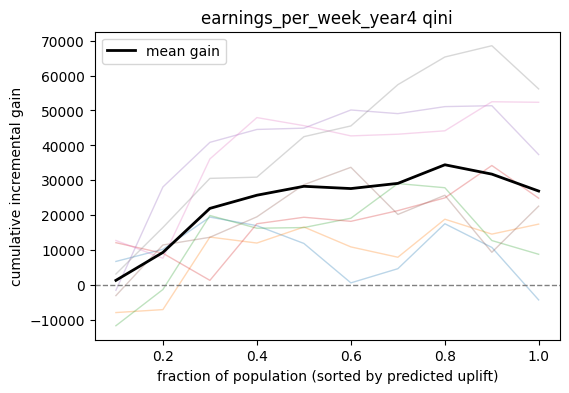

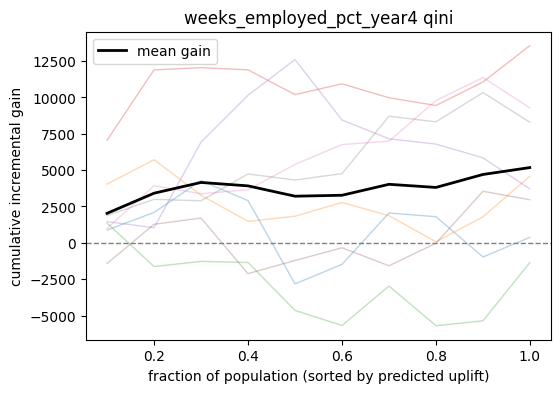

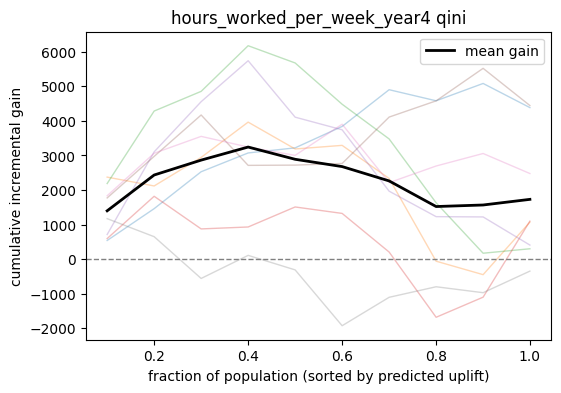

,outcome,qini_area_mean,qini_area_std,count
0,earnings_per_week_year4,22247.992881,12784.973375,8
1,hours_worked_per_week_year4,2102.374052,1384.941905,8
2,weeks_employed_pct_year4,3408.898429,4030.209346,8


In [8]:
# qini and uplift curves
if "qini_store" in locals() and qini_store:
    for outcome, curves in qini_store.items():
        curve_df = pd.concat(curves, ignore_index=True)
        mean_curve = curve_df.groupby("frac")["gain"].mean().reset_index()
        plt.figure(figsize=(6, 4))
        for split_id, sdf in curve_df.groupby("split"):
            plt.plot(sdf["frac"], sdf["gain"], alpha=0.3, linewidth=1)
        plt.plot(mean_curve["frac"], mean_curve["gain"], color="black", linewidth=2, label="mean gain")
        plt.axhline(0, color="gray", linestyle="--", linewidth=1)
        plt.xlabel("fraction of population (sorted by predicted uplift)")
        plt.ylabel("cumulative incremental gain")
        plt.title(f"{outcome} qini")
        plt.legend()
        plt.show()
    qini_summary = (
        results_df.groupby("outcome")["qini_area"]
        .agg(["mean", "std", "count"])
        .reset_index()
        .rename(columns={"mean": "qini_area_mean", "std": "qini_area_std"})
    )
    display(qini_summary)
else:
    print("no qini curves to show")
